In [1]:
library(mmge)
library(expm)
library(MASS)

Loading required package: Matrix

Attaching package: ‘expm’

The following object is masked from ‘package:Matrix’:

    expm



In [27]:
devtools::reload(pkg=".")

ℹ Reloading attached mmge


# 1. generate shared graph structure

In [3]:
m = 5
n = 5
p = 100
q = 30

In [4]:
Adj.S = matrix(0, q, q)
Adj.S[upper.tri(Adj.S)] = rbinom(q*(q-1)/2, 1, sqrt(3/q)) 
Adj.S = Adj.S + t(Adj.S)

# 2. generate precision matrices

## spatial precision matrix

In [5]:
power.S = 0.3

In [6]:
Omega.S = lapply(rep(0,m), function(x){
    Omega = matrix(0,q,q)
    Omega[upper.tri(Omega)] = (
        - runif(q*(q-1)/2, 0, power.S) * Adj.S[upper.tri(Adj.S)])
    Omega = Omega + t(Omega)
    if(min(eigen(Omega)$values)<0){
        Omega = Omega - 2*min(eigen(Omega)$values)*diag(q)
    }
    return(Omega)
})
Sigma.S = lapply(Omega.S, solve)

In [7]:
Rho.S = lapply(Omega.S, function(x){
    dgWh.S = array(rep(diag(x), q), c(q,q))
    return(x / aperm(sqrt(dgWh.S), c(2,1)) / sqrt(dgWh.S))
})

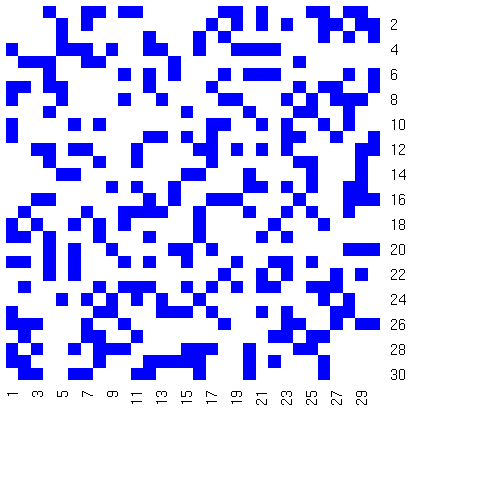

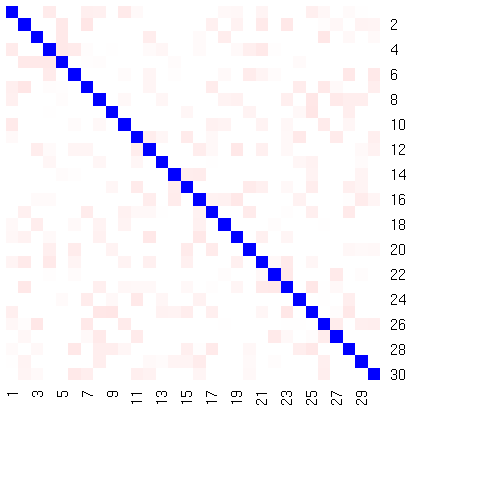

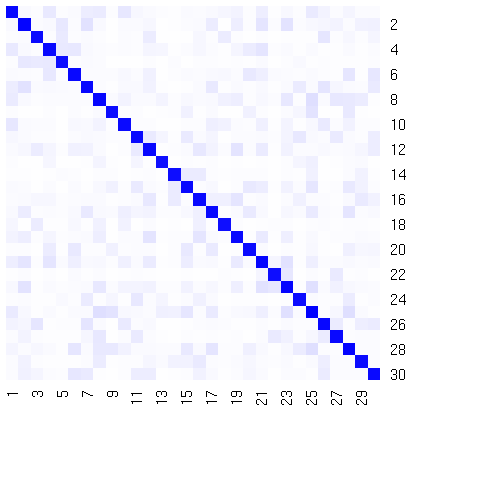

In [8]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(Omega.S[[1]])
imshow(Sigma.S[[1]])

## temporal precision matrix

In [9]:
power.T = 0.2
decay.T = 1

In [10]:
beta.T = power.T * abs(outer(1:p,1:p,FUN='-'))**(-1-decay.T)
beta.T[upper.tri(beta.T, diag=TRUE)] = 0

In [11]:
Omega.T = lapply(rep(0, m), function(x){
    t(diag(p)-beta.T) %*% (diag(p)-beta.T)})
Sigma.T = lapply(Omega.T, solve)

In [12]:
Omega.T = lapply(1:m, function(l){
  Omega.T[[l]] * sum(diag(Sigma.T[[l]])) / p  
})

Sigma.T = lapply(1:m, function(l){
  Sigma.T[[l]] * p / sum(diag(Sigma.T[[l]]))
})

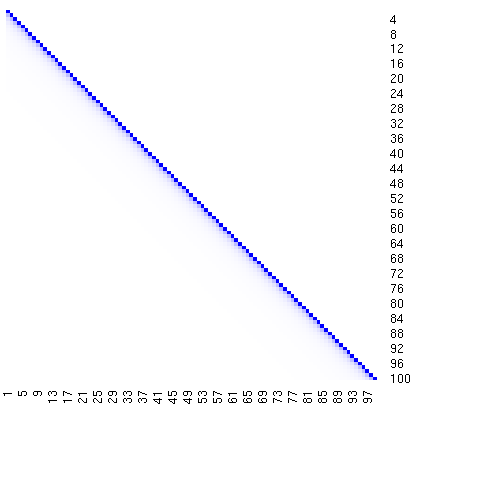

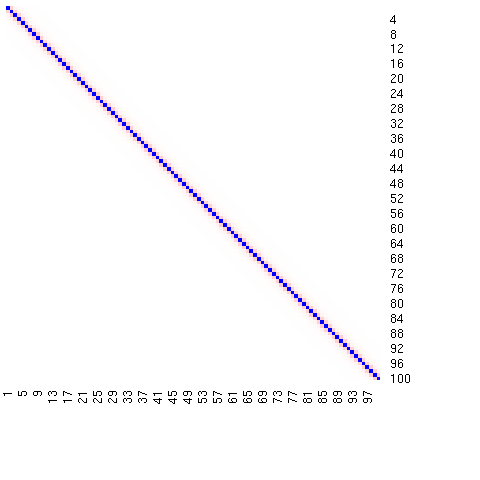

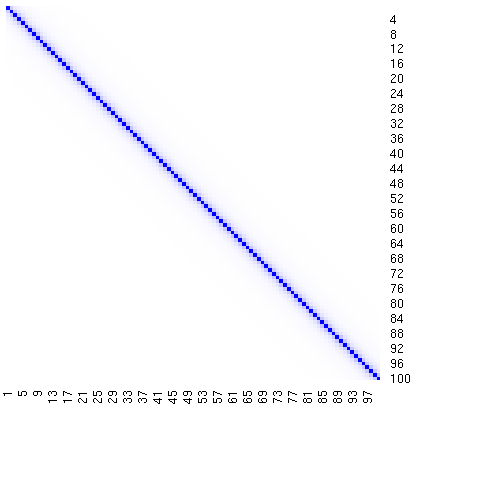

In [13]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(beta.T)
imshow(Omega.T[[1]])
imshow(Sigma.T[[1]])

# 3. simulation data according to MGGM

In [14]:
data = lapply(1:m, function(l){
    n_l = n #floor(runif(1, n, 2*n))
    return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
        sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
    }), c(p,q,n_l)))
})

In [15]:
ns = sapply(data, function(x){dim(x)[3]})

In [16]:
sess.id = c(sapply(1:m, function(l){rep(l,ns[l])}))

In [17]:
T.S = Reduce(f = "+", lapply(1:m, function(l){
    sqrt(ns[l] * p / m) * Rho.S[[l]]
}), accumulate=FALSE)

# 4. estimation by the proposed method

In [18]:
est.T = est.temporal(data, order.T=5)

In [19]:
est.S = est.spatial(data, lambdas=1e-4)

# 5. global test for multiple edges

In [20]:
num.bst = 3000

## 5.1. $E_\text{off}$

In [25]:
E.mat.off = (diag(q) == 0)
E.mat.off[lower.tri(E.mat.off, diag = TRUE)] = 0
E.mat.off = E.mat.off != 0
num.E.off = sum(1*E.mat.off)
Cov.T.E.off = cov.multiple.edge(Omega.S, Sigma.T, ns, E.mat = E.mat.off)

In [26]:
inf.S.multi.off = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                                E.mat = E.mat.off, num.bst=num.bst)

### error distribution of test statistic estimate

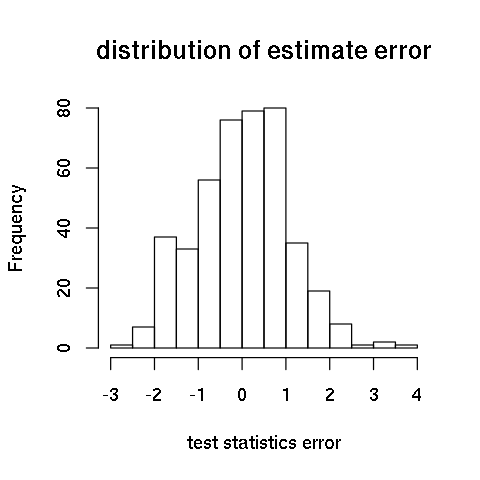

In [28]:
hist(inf.S.multi.off$T.hat.E[,1] - T.S[E.mat.off], 
     main = 'distribution of estimate error',
     xlab = 'test statistics error')

### bootstrap distribution

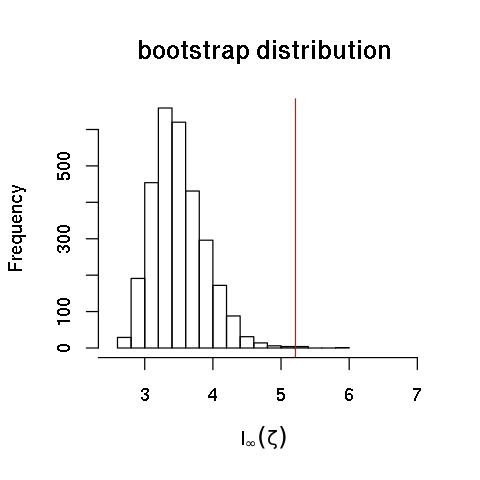

In [29]:
hist(inf.S.multi.off$l.inf.Z,
     main = 'bootstrap distribution',
     xlab = expression(l[infinity](zeta)), xlim = c(2.5, 7), xaxt="n")
abline(v = max(abs(inf.S.multi.off$T.hat.E[,1])), col='red')
axis(side=1, at=c(2, 3, 4, 5, 6, 7))

### p-value

In [30]:
inf.S.multi.off$p.value

[1] 0.001666667

## $E_\text{zero}$

In [31]:
E.mat.zero = !Adj.S
diag(E.mat.zero) = FALSE
E.mat.zero[lower.tri(E.mat.zero, diag = TRUE)] = 0
E.mat.zero = E.mat.zero != 0
num.E.zero = sum(1*E.mat.zero)
Cov.T.E.zero = cov.multiple.edge(Omega.S, Sigma.T, ns, E.mat = E.mat.zero)

In [32]:
inf.S.multi.zero = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                                     E.mat = E.mat.zero, num.bst=num.bst)

### error distribution of test statistic estimate

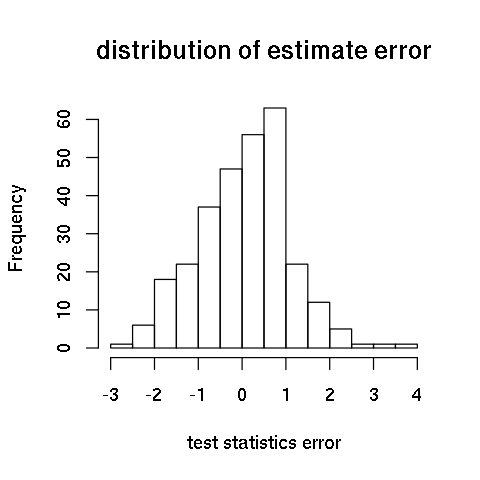

In [33]:
hist(inf.S.multi.zero$T.hat.E[,1] - T.S[E.mat.zero], 
     main = 'distribution of estimate error',
     xlab = 'test statistics error')

### bootstrap distribution

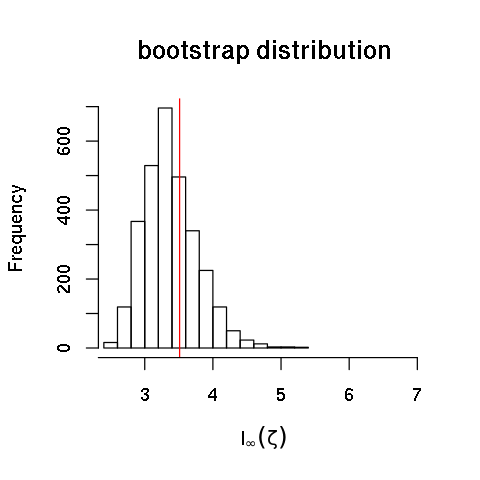

In [34]:
hist(inf.S.multi.zero$l.inf.Z,
     main = 'bootstrap distribution',
     xlab = expression(l[infinity](zeta)), xlim = c(2.5, 7), xaxt="n")
abline(v = max(abs(inf.S.multi.zero$T.hat.E[,1])), col='red')
axis(side=1, at=c(2, 3, 4, 5, 6, 7))

### p-value

In [35]:
inf.S.multi.zero$p.value

[1] 0.3246667

# 6. iterate simulation for empirical distirbution of test statistic

In [81]:
num.sim = 1000

In [82]:
T.hat.sim = array(0, c(q,q,num.sim))

In [83]:
for( i.sim in 1:num.sim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.single.edge(est.S$W.hat.S, est.T$S.hat.T, ns)
    T.hat.sim[,,i.sim] = inf.S$T.hat
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  10.756 sec. 
2 -th simulation finished, lapse:  10.513 sec. 
3 -th simulation finished, lapse:  8.986 sec. 
4 -th simulation finished, lapse:  9.305 sec. 
5 -th simulation finished, lapse:  8.536 sec. 
6 -th simulation finished, lapse:  9.747 sec. 
7 -th simulation finished, lapse:  9.592 sec. 
8 -th simulation finished, lapse:  6.8 sec. 
9 -th simulation finished, lapse:  7.545 sec. 
10 -th simulation finished, lapse:  8.474 sec. 
11 -th simulation finished, lapse:  13.663 sec. 
12 -th simulation finished, lapse:  9.914 sec. 
13 -th simulation finished, lapse:  9.025 sec. 
14 -th simulation finished, lapse:  6.359 sec. 
15 -th simulation finished, lapse:  7.148 sec. 
16 -th simulation finished, lapse:  13.428 sec. 
17 -th simulation finished, lapse:  11.464 sec. 
18 -th simulation finished, lapse:  8.776 sec. 
19 -th simulation finished, lapse:  8.289 sec. 
20 -th simulation finished, lapse:  9.392 sec. 
21 -th simulation finished, lapse:  9.542 sec.

170 -th simulation finished, lapse:  6.504 sec. 
171 -th simulation finished, lapse:  8.015 sec. 
172 -th simulation finished, lapse:  8.672 sec. 
173 -th simulation finished, lapse:  8.738 sec. 
174 -th simulation finished, lapse:  8.102 sec. 
175 -th simulation finished, lapse:  10.614 sec. 
176 -th simulation finished, lapse:  8.452 sec. 
177 -th simulation finished, lapse:  7.686 sec. 
178 -th simulation finished, lapse:  9.801 sec. 
179 -th simulation finished, lapse:  8.867 sec. 
180 -th simulation finished, lapse:  10.083 sec. 
181 -th simulation finished, lapse:  12.146 sec. 
182 -th simulation finished, lapse:  11.921 sec. 
183 -th simulation finished, lapse:  10.029 sec. 
184 -th simulation finished, lapse:  9.713 sec. 
185 -th simulation finished, lapse:  10.502 sec. 
186 -th simulation finished, lapse:  9.378 sec. 
187 -th simulation finished, lapse:  10.081 sec. 
188 -th simulation finished, lapse:  12.424 sec. 
189 -th simulation finished, lapse:  11.37 sec. 
190 -th simu

336 -th simulation finished, lapse:  10.909 sec. 
337 -th simulation finished, lapse:  9.142 sec. 
338 -th simulation finished, lapse:  9.514 sec. 
339 -th simulation finished, lapse:  9.921 sec. 
340 -th simulation finished, lapse:  11.161 sec. 
341 -th simulation finished, lapse:  7.177 sec. 
342 -th simulation finished, lapse:  8.709 sec. 
343 -th simulation finished, lapse:  8.281 sec. 
344 -th simulation finished, lapse:  9.393 sec. 
345 -th simulation finished, lapse:  13.341 sec. 
346 -th simulation finished, lapse:  11.507 sec. 
347 -th simulation finished, lapse:  7.772 sec. 
348 -th simulation finished, lapse:  7.944 sec. 
349 -th simulation finished, lapse:  6.475 sec. 
350 -th simulation finished, lapse:  7.2 sec. 
351 -th simulation finished, lapse:  10.882 sec. 
352 -th simulation finished, lapse:  8.532 sec. 
353 -th simulation finished, lapse:  6.479 sec. 
354 -th simulation finished, lapse:  9.283 sec. 
355 -th simulation finished, lapse:  8.236 sec. 
356 -th simulatio

515 -th simulation finished, lapse:  9.876 sec. 
516 -th simulation finished, lapse:  9.305 sec. 
517 -th simulation finished, lapse:  8.747 sec. 
518 -th simulation finished, lapse:  10.372 sec. 
519 -th simulation finished, lapse:  9.961 sec. 
520 -th simulation finished, lapse:  9.735 sec. 
521 -th simulation finished, lapse:  10.97 sec. 
522 -th simulation finished, lapse:  7.162 sec. 
523 -th simulation finished, lapse:  9.077 sec. 
524 -th simulation finished, lapse:  7.784 sec. 
525 -th simulation finished, lapse:  9.675 sec. 
526 -th simulation finished, lapse:  10.282 sec. 
527 -th simulation finished, lapse:  7.529 sec. 
528 -th simulation finished, lapse:  8.383 sec. 
529 -th simulation finished, lapse:  9.711 sec. 
530 -th simulation finished, lapse:  9.607 sec. 
531 -th simulation finished, lapse:  9.737 sec. 
532 -th simulation finished, lapse:  10.289 sec. 
533 -th simulation finished, lapse:  7.887 sec. 
534 -th simulation finished, lapse:  9.8 sec. 
535 -th simulation 

682 -th simulation finished, lapse:  11.036 sec. 
683 -th simulation finished, lapse:  11.02 sec. 
684 -th simulation finished, lapse:  10.834 sec. 
685 -th simulation finished, lapse:  7.995 sec. 
686 -th simulation finished, lapse:  9.482 sec. 
687 -th simulation finished, lapse:  7.833 sec. 
688 -th simulation finished, lapse:  13.864 sec. 
689 -th simulation finished, lapse:  13.116 sec. 
690 -th simulation finished, lapse:  11.247 sec. 
691 -th simulation finished, lapse:  12.694 sec. 
692 -th simulation finished, lapse:  9.139 sec. 
693 -th simulation finished, lapse:  7.887 sec. 
694 -th simulation finished, lapse:  9.656 sec. 
695 -th simulation finished, lapse:  8.836 sec. 
696 -th simulation finished, lapse:  9.604 sec. 
697 -th simulation finished, lapse:  10.122 sec. 
698 -th simulation finished, lapse:  7.594 sec. 
699 -th simulation finished, lapse:  9.977 sec. 
700 -th simulation finished, lapse:  10.568 sec. 
701 -th simulation finished, lapse:  13.635 sec. 
702 -th sim

849 -th simulation finished, lapse:  5.732 sec. 
850 -th simulation finished, lapse:  6.506 sec. 
851 -th simulation finished, lapse:  5.595 sec. 
852 -th simulation finished, lapse:  4.081 sec. 
853 -th simulation finished, lapse:  4.217 sec. 
854 -th simulation finished, lapse:  4.083 sec. 
855 -th simulation finished, lapse:  4.222 sec. 
856 -th simulation finished, lapse:  4.098 sec. 
857 -th simulation finished, lapse:  4.216 sec. 
858 -th simulation finished, lapse:  4.1 sec. 
859 -th simulation finished, lapse:  4.227 sec. 
860 -th simulation finished, lapse:  4.187 sec. 
861 -th simulation finished, lapse:  4.111 sec. 
862 -th simulation finished, lapse:  4.278 sec. 
863 -th simulation finished, lapse:  4.269 sec. 
864 -th simulation finished, lapse:  4.392 sec. 
865 -th simulation finished, lapse:  4.114 sec. 
866 -th simulation finished, lapse:  4.25 sec. 
867 -th simulation finished, lapse:  4.095 sec. 
868 -th simulation finished, lapse:  4.165 sec. 
869 -th simulation fini

## empirical distribution of simulated test statistics

In [84]:
T.hat.E.off = apply(T.hat.sim, 3, function(T.hat){ T.hat[E.mat.off] })
l.inf.T.off = apply(T.hat.E.off, 2, function(T.hat){ max(abs(T.hat)) })

In [85]:
l.inf.dT.off = apply(T.hat.E.off - T.S[E.mat.off],
                     2, function(T.hat){ max(abs(T.hat)) })

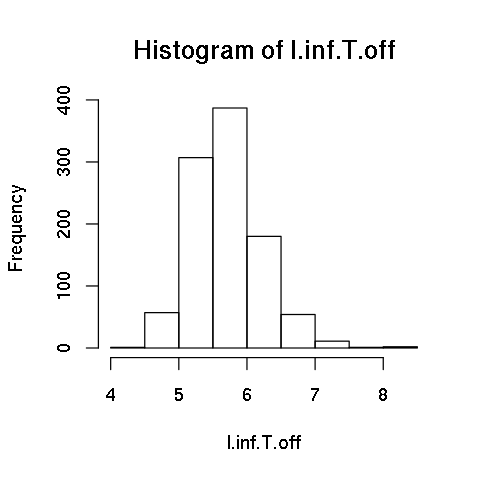

In [86]:
hist(l.inf.T.off)

In [87]:
T.hat.E.zero = apply(T.hat.sim, 3, function(T.hat){ T.hat[E.mat.zero] })
l.inf.T.zero = apply(T.hat.E.zero, 2, function(T.hat){ max(abs(T.hat)) })

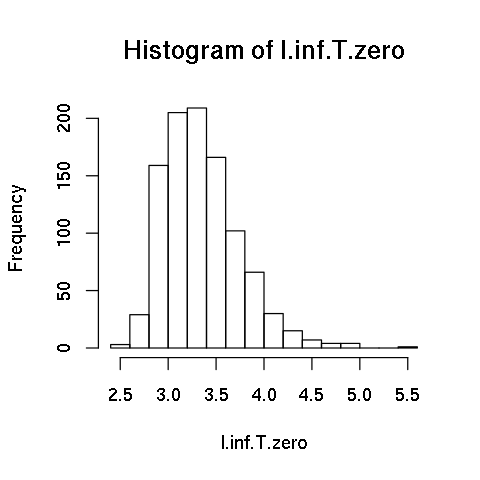

In [88]:
hist(l.inf.T.zero)

## comparison between simulation and bootstrap distributions

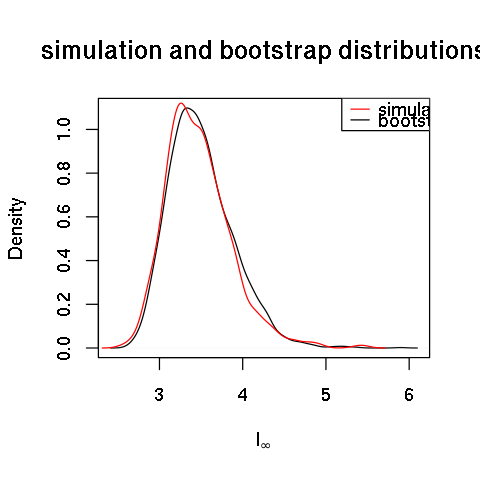

In [89]:
plot(density(inf.S.multi.off$l.inf.Z), col='black',
     main = 'simulation and bootstrap distributions',
     xlab = expression(l[infinity]))
lines(density(l.inf.dT.off), col='red')
legend('topright',
       legend=c('simulation','bootstrap'), 
       col=c('red','black'), lty=c(1,1))

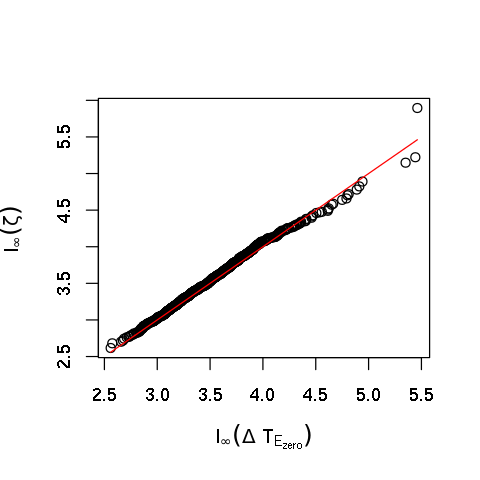

In [90]:
qqplot(l.inf.dT.off, inf.S.multi.off$l.inf.Z,
       xlab=expression(l[infinity](Delta~T[E[zero]])),
       ylab=expression(l[infinity](zeta)))
lines(l.inf.dT.off, l.inf.dT.off, col='red')

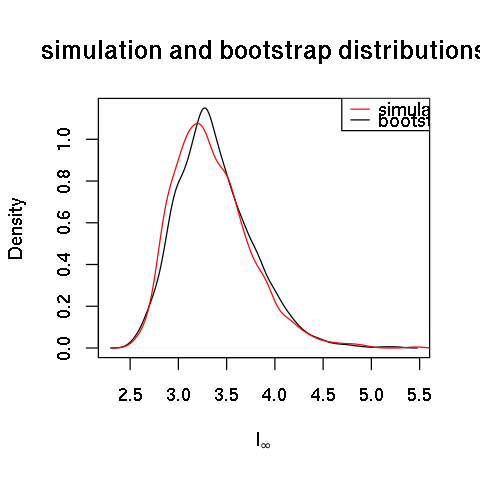

In [91]:
plot(density(inf.S.multi.zero$l.inf.Z), col='black',
     main = 'simulation and bootstrap distributions',
     xlab = expression(l[infinity]))
lines(density(l.inf.T.zero), col='red')
legend('topright',
       legend=c('simulation','bootstrap'), 
       col=c('red','black'), lty=c(1,1))

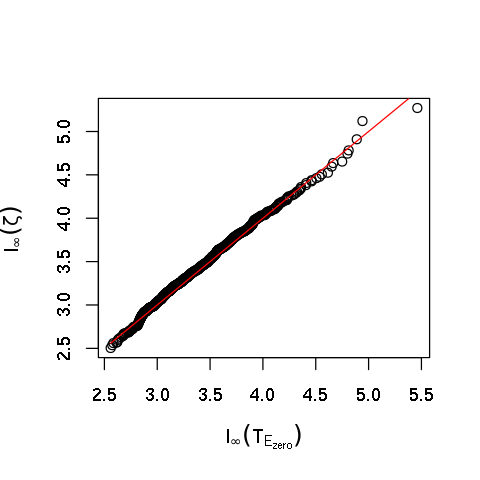

In [92]:
qqplot(l.inf.T.zero, inf.S.multi.zero$l.inf.Z,
       xlab=expression(l[infinity](T[E[zero]])),
       ylab=expression(l[infinity](zeta)))
lines(l.inf.T.zero, l.inf.T.zero, col='red')

In [ ]:
# save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
#      inf.S.multi.off, inf.S.multi.zero, 
#      T.hat.sim, file='sim_random_multi.Rdata')

# 7. Coverage study

In [93]:
num.msim = 100

## $E_\text{off}$

In [94]:
T.hat.E.sim = array(0, c(num.E.off,num.msim))
l.inf.Z.sim = array(0, c(num.bst,num.msim))
p.value.sim = rep(0, num.msim)

In [95]:
for( i.sim in 1:num.msim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                              E.mat=E.mat.off, num.bst=num.bst)
    
    T.hat.E.sim[,i.sim] = inf.S$T.hat.E
    l.inf.Z.sim[,i.sim] = inf.S$l.inf.Z
    p.value.sim[i.sim] = inf.S$p.value
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  19.988 sec. 
2 -th simulation finished, lapse:  20.953 sec. 
3 -th simulation finished, lapse:  20.651 sec. 
4 -th simulation finished, lapse:  19.785 sec. 
5 -th simulation finished, lapse:  20.657 sec. 
6 -th simulation finished, lapse:  19.542 sec. 
7 -th simulation finished, lapse:  20.697 sec. 
8 -th simulation finished, lapse:  19.02 sec. 
9 -th simulation finished, lapse:  19.322 sec. 
10 -th simulation finished, lapse:  19.421 sec. 
11 -th simulation finished, lapse:  19.47 sec. 
12 -th simulation finished, lapse:  19.389 sec. 
13 -th simulation finished, lapse:  19.38 sec. 
14 -th simulation finished, lapse:  19.078 sec. 
15 -th simulation finished, lapse:  19.013 sec. 
16 -th simulation finished, lapse:  18.936 sec. 
17 -th simulation finished, lapse:  19.444 sec. 
18 -th simulation finished, lapse:  19.553 sec. 
19 -th simulation finished, lapse:  19.155 sec. 
20 -th simulation finished, lapse:  18.769 sec. 
21 -th simulation finished, laps

In [52]:
# l.inf.dT.sim = apply(T.hat.E.sim - T.S[E.mat.off],
#                      2, function(T.hat){ max(abs(T.hat)) })

In [96]:
q.Z.sim = apply(l.inf.Z.sim, 2, function(l){
    quantile(l, c(0.925, 0.95, 0.975))
})

In [97]:
q.dT.sim = apply(q.Z.sim, 2, function(q){
    sapply(q, function(x){ mean(l.inf.dT.off < x) })
})

In [98]:
apply(q.dT.sim, 1, mean)

92.5%     95%   97.5% 
0.93461 0.95564 0.97648

In [99]:
apply(q.dT.sim, 1, sd)

92.5%         95%       97.5% 
0.003177875 0.003198863 0.002426620

In [103]:
# save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
#      E.mat.off, l.inf.dT.off, l.inf.Z.sim, p.value.sim,
#      file='sim_random_multi_off.Rdata')

## $E_\text{zero}$

In [104]:
T.hat.E.sim = array(0, c(num.E.zero,num.msim))
l.inf.Z.sim = array(0, c(num.bst,num.msim))
p.value.sim = rep(0, num.msim)

In [105]:
for( i.sim in 1:num.msim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                              E.mat=E.mat.zero, num.bst=num.bst)
    
    T.hat.E.sim[,i.sim] = inf.S$T.hat.E
    l.inf.Z.sim[,i.sim] = inf.S$l.inf.Z
    p.value.sim[i.sim] = inf.S$p.value
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  10.935 sec. 
2 -th simulation finished, lapse:  12.771 sec. 
3 -th simulation finished, lapse:  12.632 sec. 
4 -th simulation finished, lapse:  13.039 sec. 
5 -th simulation finished, lapse:  12.099 sec. 
6 -th simulation finished, lapse:  14.552 sec. 
7 -th simulation finished, lapse:  12.143 sec. 
8 -th simulation finished, lapse:  13.85 sec. 
9 -th simulation finished, lapse:  12.788 sec. 
10 -th simulation finished, lapse:  11.267 sec. 
11 -th simulation finished, lapse:  14.475 sec. 
12 -th simulation finished, lapse:  12.279 sec. 
13 -th simulation finished, lapse:  13.819 sec. 
14 -th simulation finished, lapse:  12.237 sec. 
15 -th simulation finished, lapse:  11.659 sec. 
16 -th simulation finished, lapse:  15.443 sec. 
17 -th simulation finished, lapse:  12.054 sec. 
18 -th simulation finished, lapse:  14.15 sec. 
19 -th simulation finished, lapse:  14.374 sec. 
20 -th simulation finished, lapse:  12.318 sec. 
21 -th simulation finished, lap

168 -th simulation finished, lapse:  12.266 sec. 
169 -th simulation finished, lapse:  10.813 sec. 
170 -th simulation finished, lapse:  13.017 sec. 
171 -th simulation finished, lapse:  11.423 sec. 
172 -th simulation finished, lapse:  11.387 sec. 
173 -th simulation finished, lapse:  12.318 sec. 
174 -th simulation finished, lapse:  11.308 sec. 
175 -th simulation finished, lapse:  11.542 sec. 
176 -th simulation finished, lapse:  12.348 sec. 
177 -th simulation finished, lapse:  11.463 sec. 
178 -th simulation finished, lapse:  11.479 sec. 
179 -th simulation finished, lapse:  11.716 sec. 
180 -th simulation finished, lapse:  11.434 sec. 
181 -th simulation finished, lapse:  12.23 sec. 
182 -th simulation finished, lapse:  11.576 sec. 
183 -th simulation finished, lapse:  11.175 sec. 
184 -th simulation finished, lapse:  12.531 sec. 
185 -th simulation finished, lapse:  11.653 sec. 
186 -th simulation finished, lapse:  11.118 sec. 
187 -th simulation finished, lapse:  12.182 sec. 
1

In [ ]:
# l.inf.dT.sim = apply(T.hat.E.sim - T.S[E.mat.off],
#                      2, function(T.hat){ max(abs(T.hat)) })

In [107]:
q.Z.sim = apply(l.inf.Z.sim, 2, function(l){
    quantile(l, c(0.925, 0.95, 0.975))
})

In [108]:
q.dT.sim = apply(q.Z.sim, 2, function(q){
    sapply(q, function(x){ mean(l.inf.T.zero < x) })
})

In [109]:
apply(q.dT.sim, 1, mean)

92.5%     95%   97.5% 
0.93786 0.95452 0.97748

In [110]:
apply(q.dT.sim, 1, sd)

92.5%         95%       97.5% 
0.003197284 0.004368112 0.002333247

In [111]:
# save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
#      E.mat.zero, l.inf.T.zero, l.inf.Z.sim, p.value.sim,
#      file='sim_random_multi_zero.Rdata')